Dataset Shape: (418, 12)

Missing Values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Data Types:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object


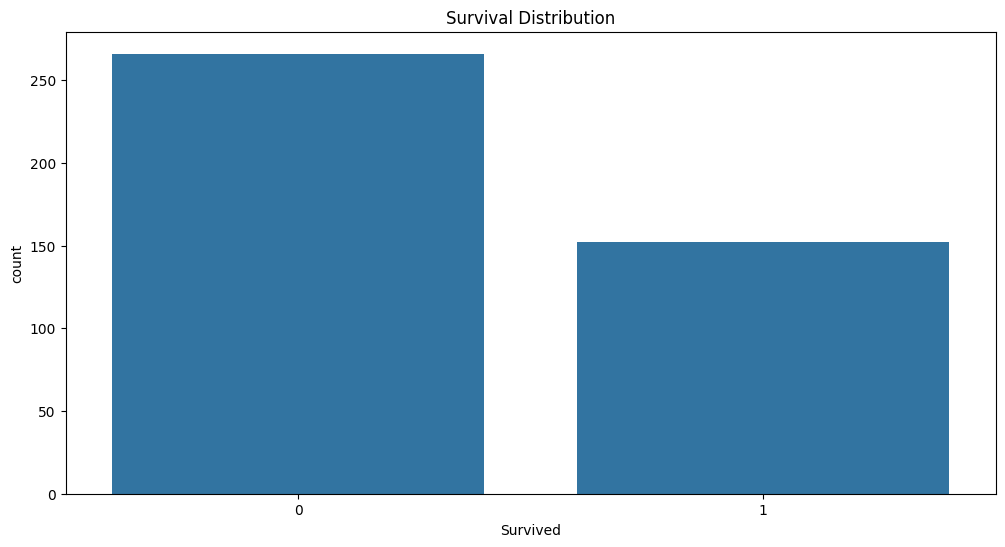

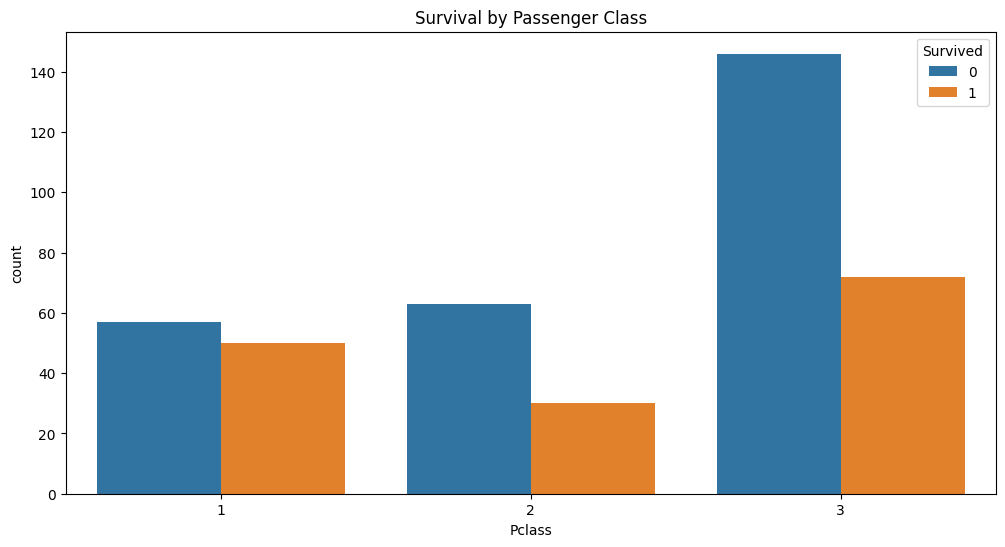

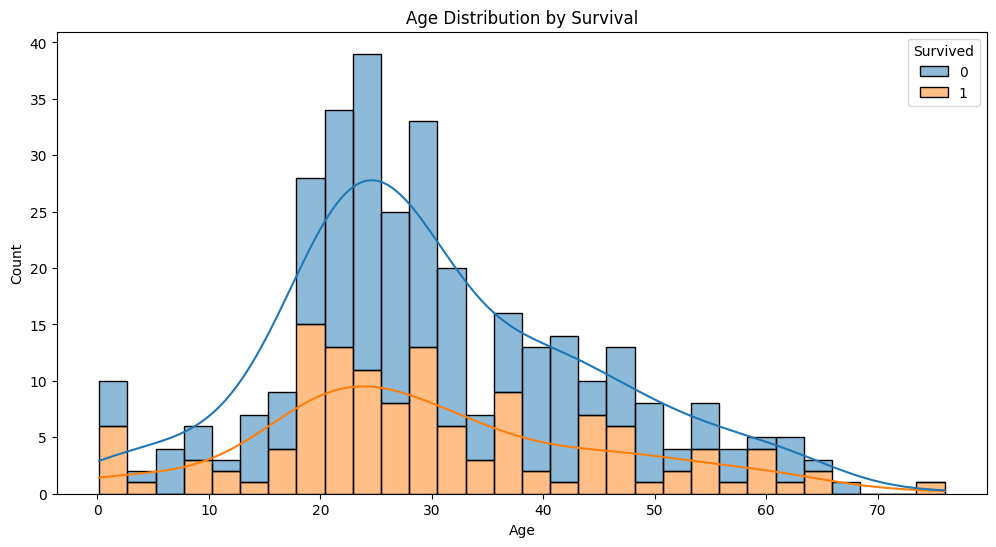

Random Forest: Mean Accuracy = 1.0000, Std = 0.0000
Logistic Regression: Mean Accuracy = 1.0000, Std = 0.0000
Gradient Boosting: Mean Accuracy = 1.0000, Std = 0.0000
SVM: Mean Accuracy = 0.9791, Std = 0.0223


/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: divide by zero encountered in divide
  f = msb / msw



Best Parameters: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best CV Accuracy: 1.0

Test Set Performance:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
ROC AUC: 1.0


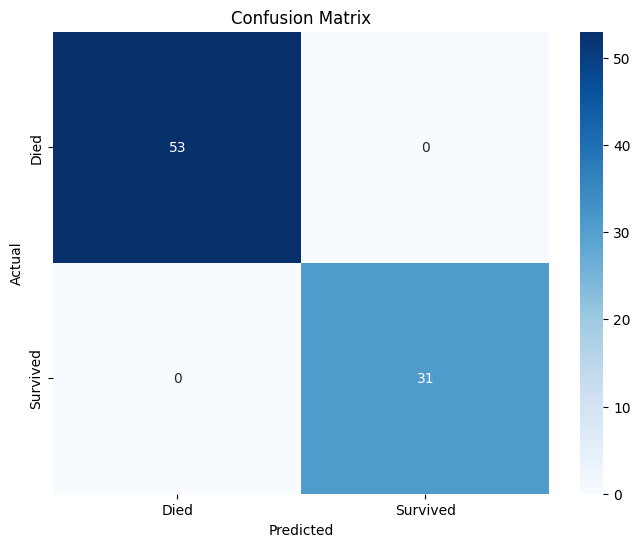


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       1.00      1.00      1.00        31

    accuracy                           1.00        84
   macro avg       1.00      1.00      1.00        84
weighted avg       1.00      1.00      1.00        84



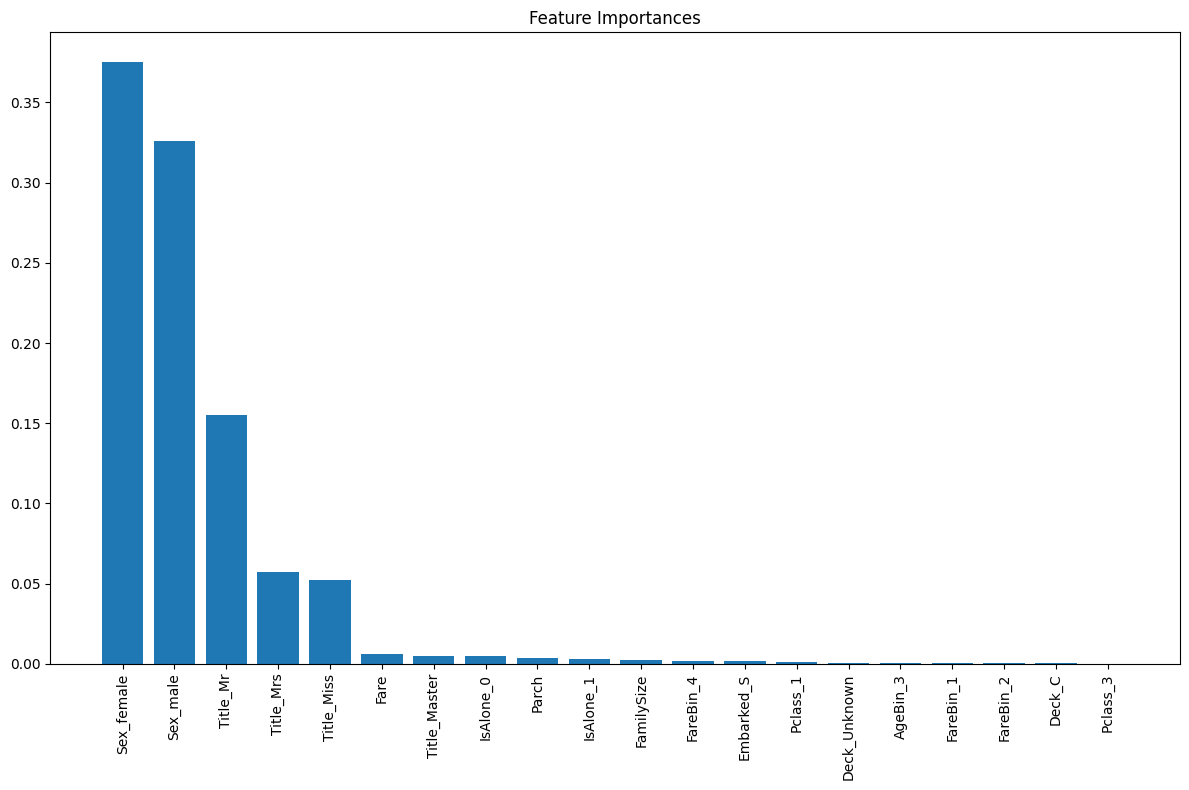

['titanic_survival_model.pkl']

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA

# Load the dataset
df = pd.read_csv('/content/tested.csv')

# Exploratory Data Analysis
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

# Visualizations
plt.figure(figsize=(12, 6))
sns.countplot(x='Survived', data=df)
plt.title('Survival Distribution')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Survival by Passenger Class')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(x='Age', hue='Survived', data=df, bins=30, kde=True, multiple='stack')
plt.title('Age Distribution by Survival')
plt.show()

# Feature Engineering
def preprocess_data(df):
    # Create new features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Extract title from name
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr',
                                      'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace('Mlle', 'Miss')
    df['Title'] = df['Title'].replace('Ms', 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    # Extract deck from cabin
    df['Deck'] = df['Cabin'].str[0]
    df['Deck'] = df['Deck'].fillna('Unknown')

    # Create fare bins
    df['FareBin'] = pd.qcut(df['Fare'], 4, labels=[1, 2, 3, 4])

    # Create age bins
    df['AgeBin'] = pd.cut(df['Age'].fillna(df['Age'].median()),
                         bins=[0, 12, 20, 40, 60, 100], labels=[1, 2, 3, 4, 5])

    # Drop unnecessary columns
    df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)

    return df

df = preprocess_data(df)

# Define features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define numerical and categorical features
numerical_features = ['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize']
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Title', 'Deck', 'IsAlone', 'FareBin', 'AgeBin']

# Create preprocessing pipelines
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features)
])

# Feature selection and model pipeline
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_classif, k=20)),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Define models to try
models = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Evaluate models using cross-validation
results = {}
for name, model in models.items():
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
    results[name] = cv_scores
    print(f"{name}: Mean Accuracy = {cv_scores.mean():.4f}, Std = {cv_scores.std():.4f}")

# Hyperparameter tuning for the best model (Random Forest)
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(full_pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nBest Parameters:", grid_search.best_params_)
print("Best CV Accuracy:", grid_search.best_score_)

# Train the best model
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Performance metrics
print("\nTest Set Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Died', 'Survived'], yticklabels=['Died', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature importance (for tree-based models)
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    # Get feature names after preprocessing
    preprocessor.fit(X_train)
    num_features = numerical_features
    cat_features = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_features)
    all_features = np.concatenate([num_features, cat_features])

    # Get selected features
    selected_mask = best_model.named_steps['feature_selection'].get_support()
    selected_features = all_features[selected_mask]

    # Get feature importances
    importances = best_model.named_steps['classifier'].feature_importances_
    indices = np.argsort(importances)[::-1]

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    plt.title("Feature Importances")
    plt.bar(range(len(selected_features)), importances[indices], align="center")
    plt.xticks(range(len(selected_features)), selected_features[indices], rotation=90)
    plt.tight_layout()
    plt.show()

# Save the model (optional)
import joblib
joblib.dump(best_model, 'titanic_survival_model.pkl')

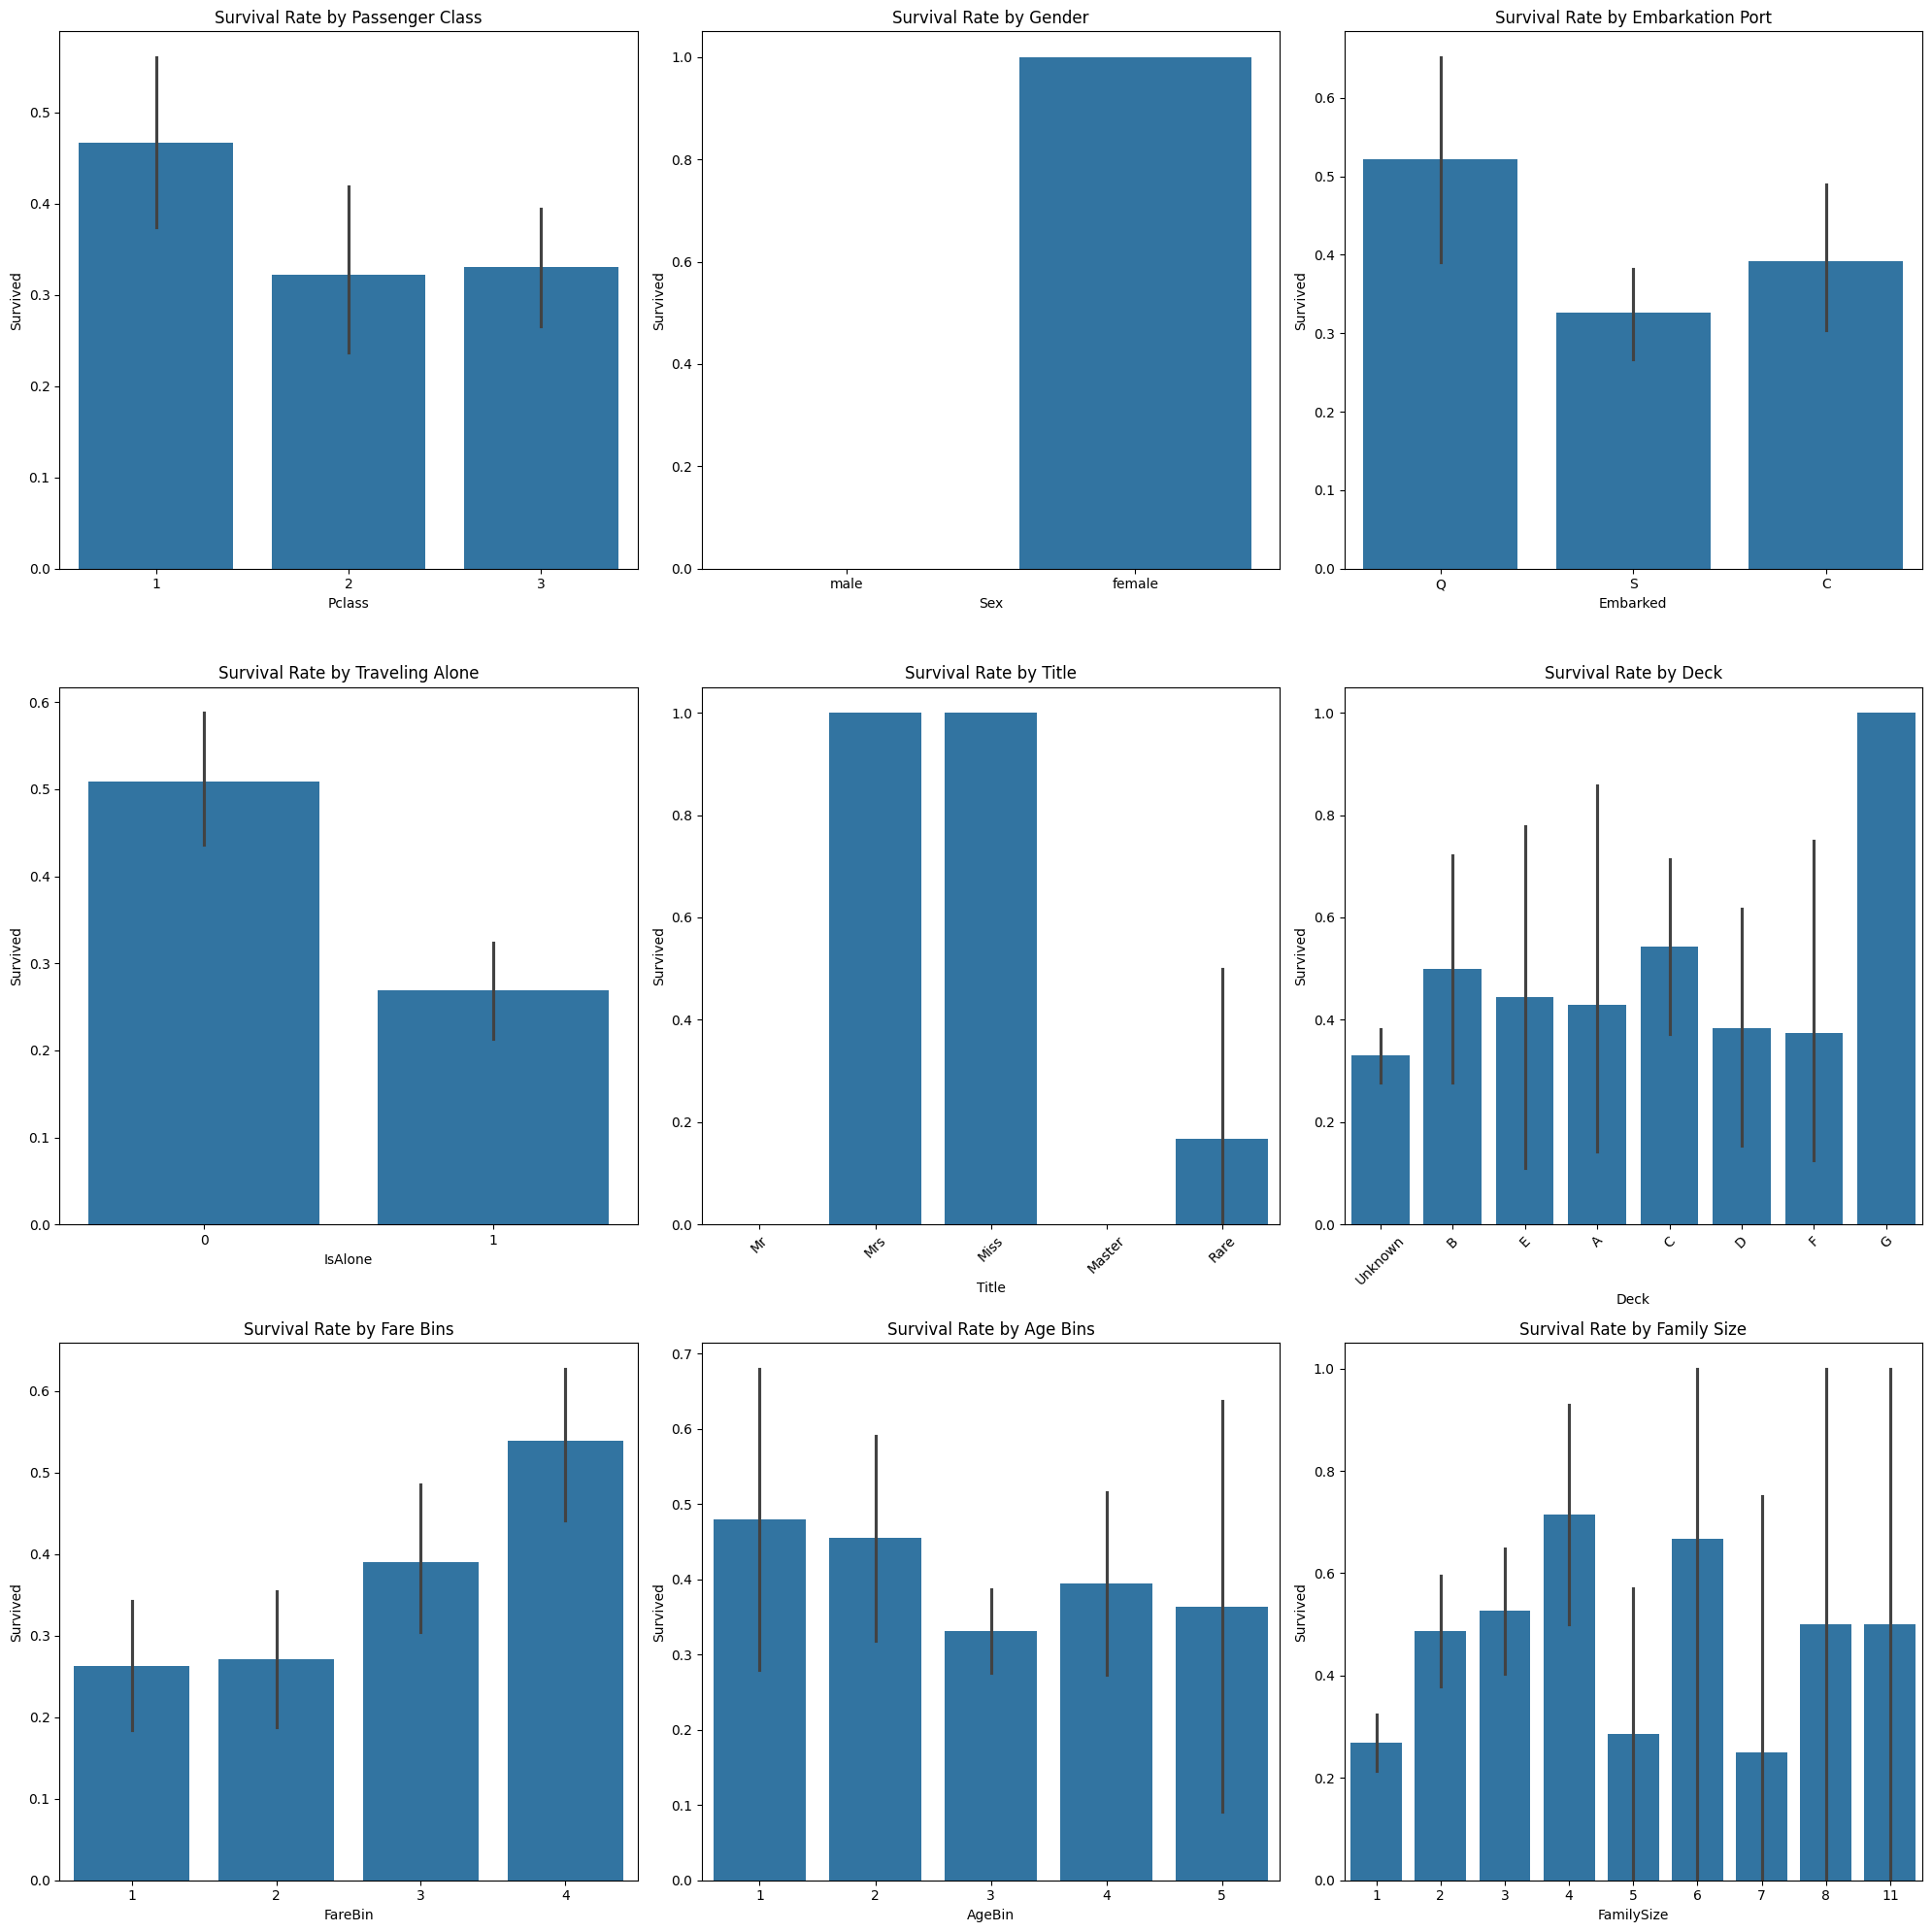

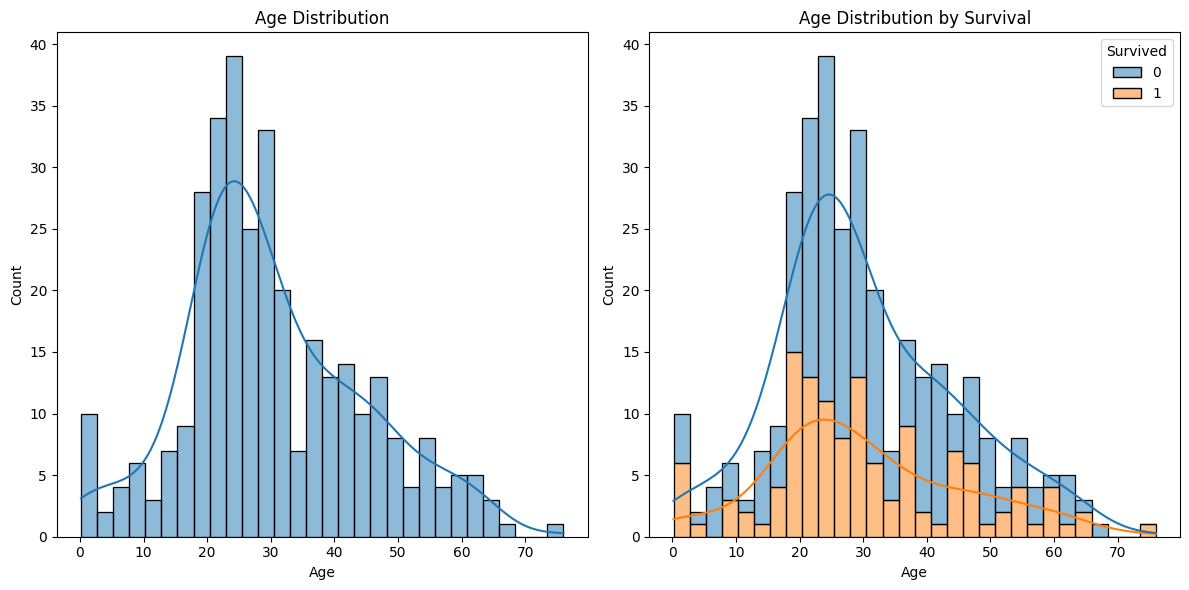

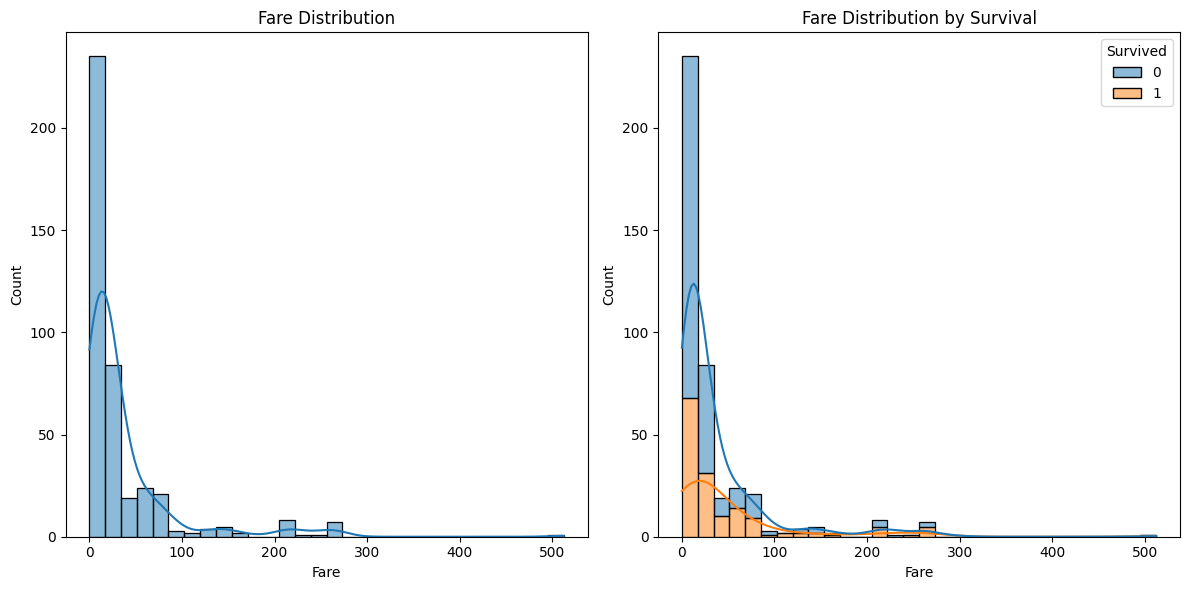

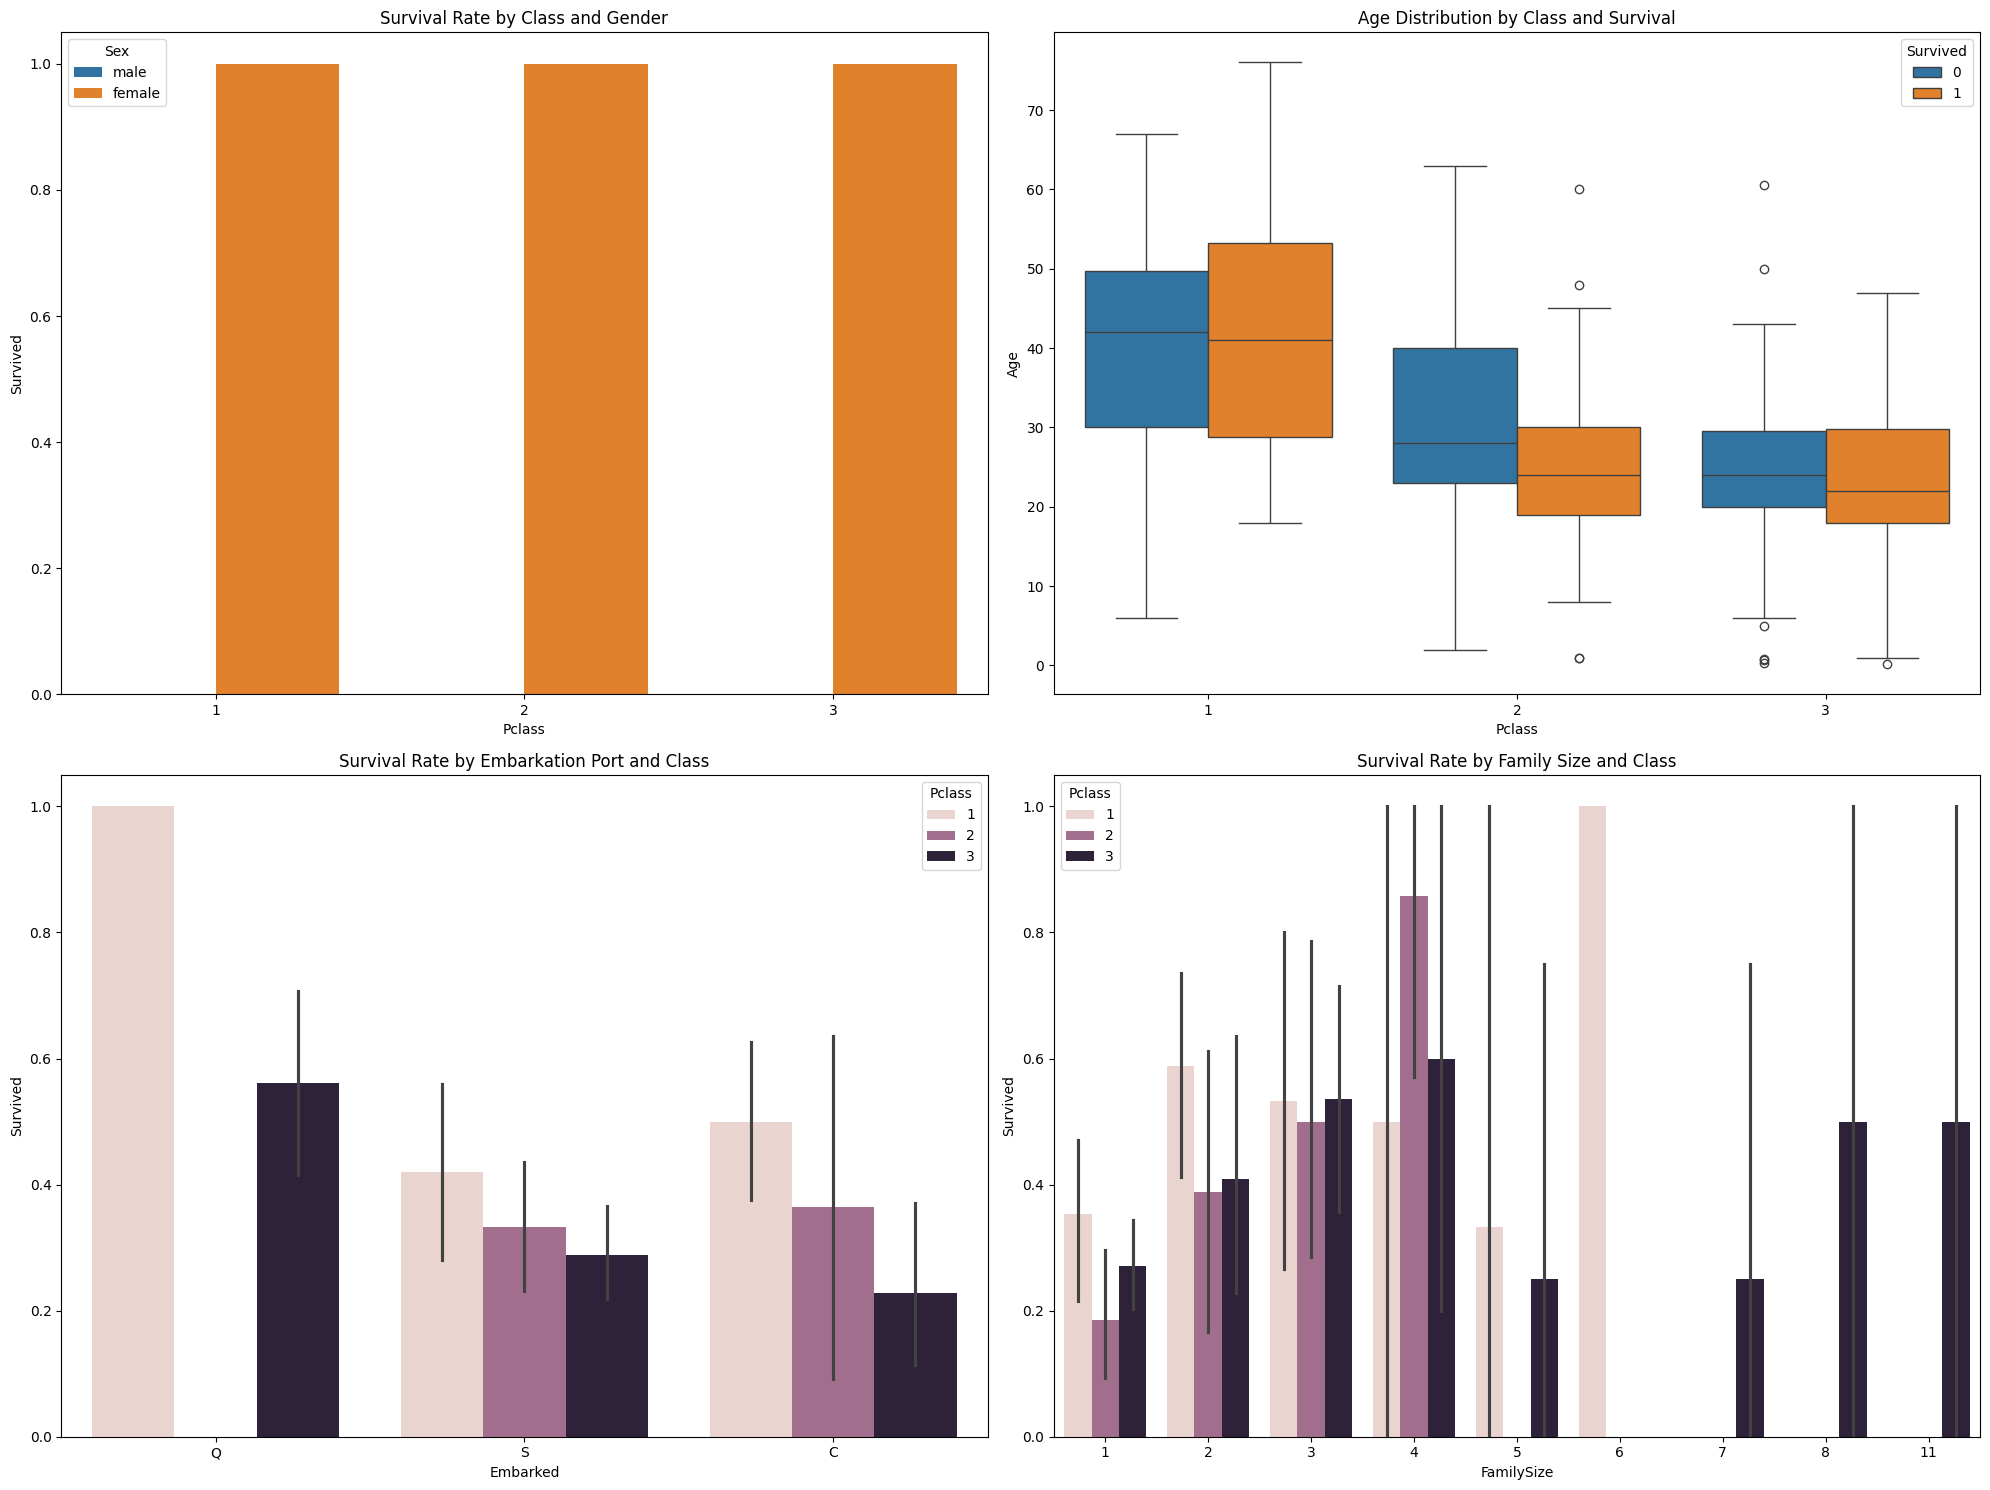

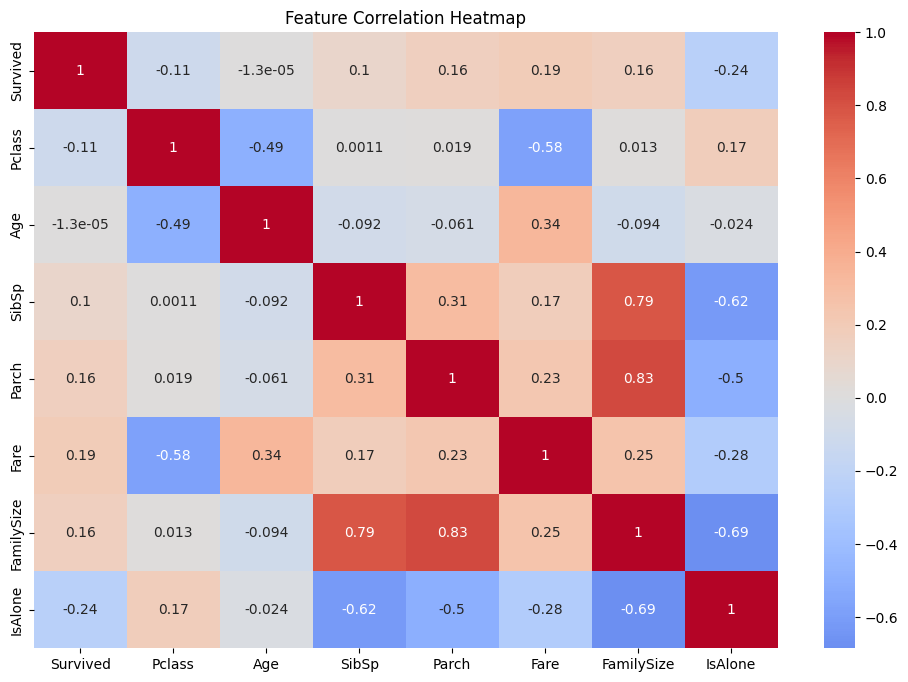

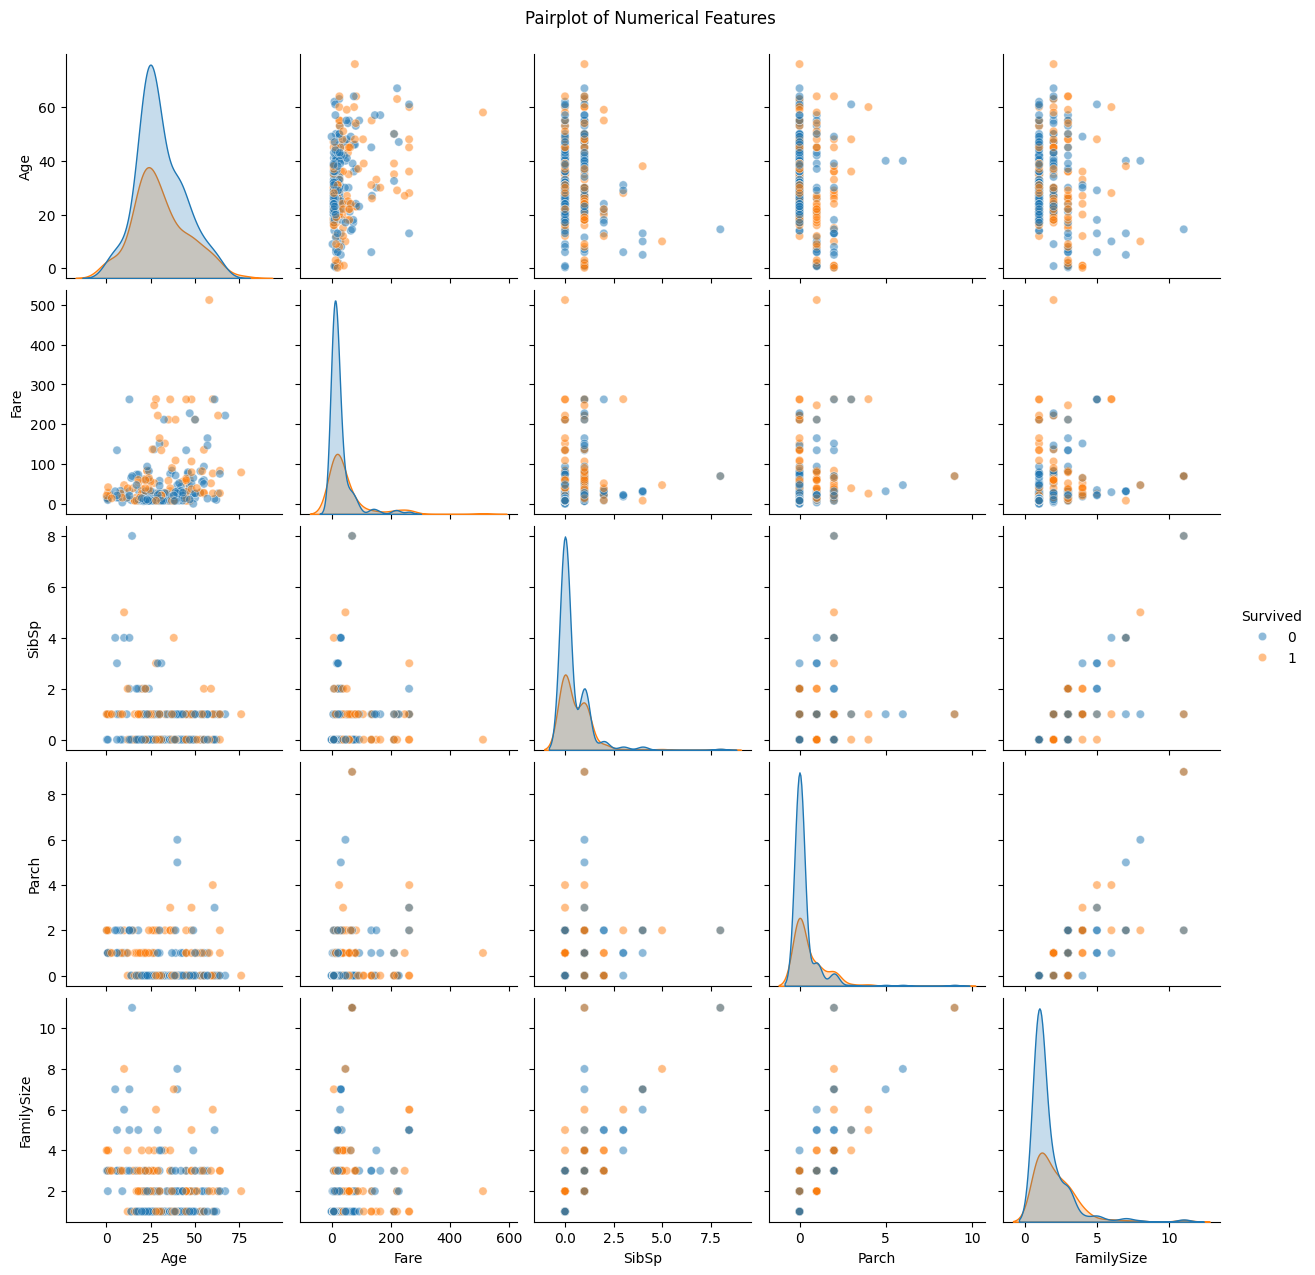

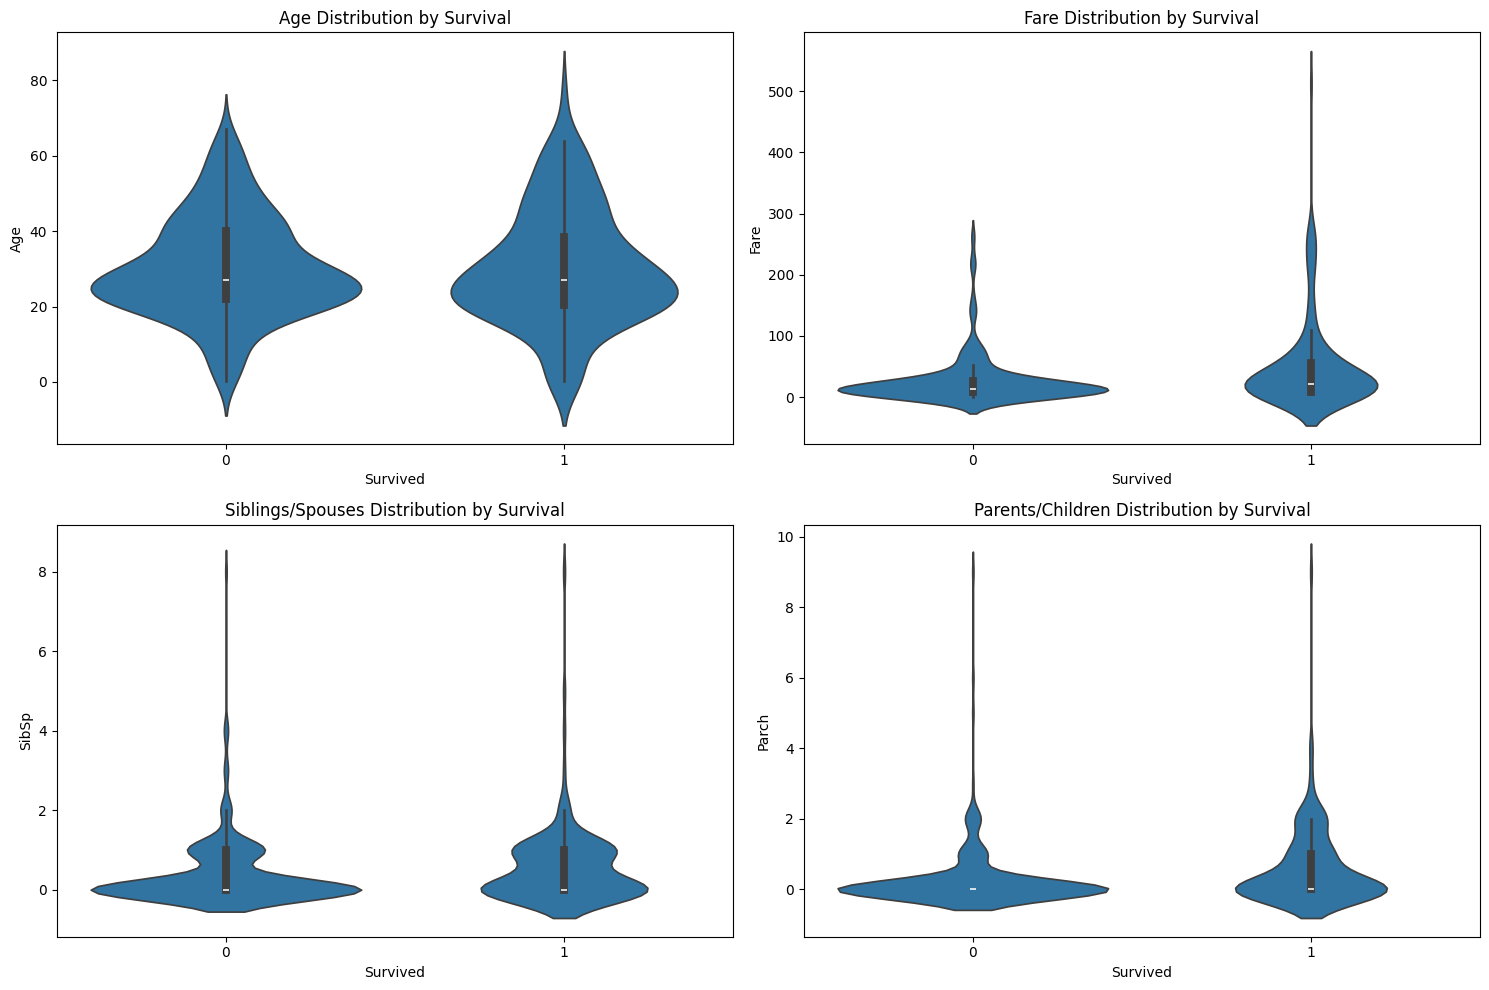

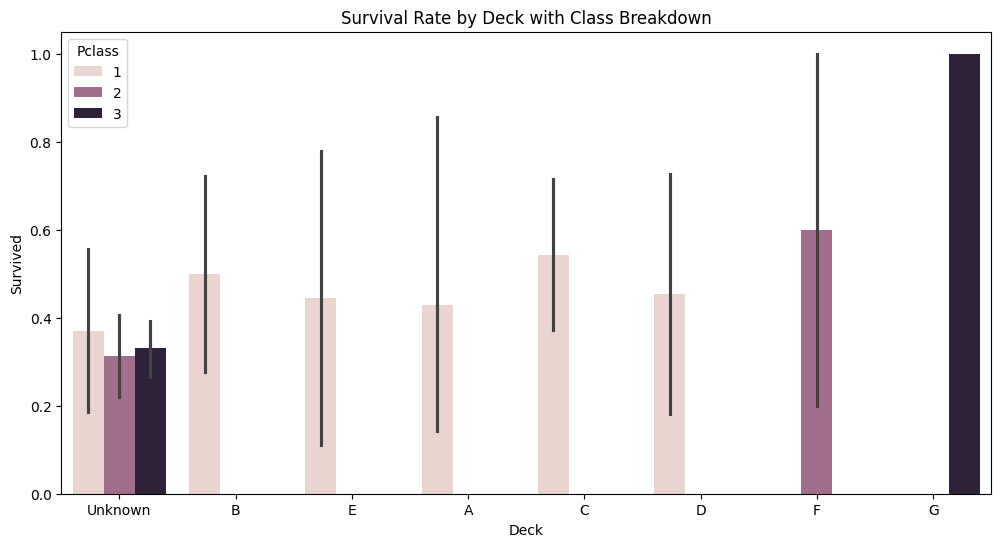

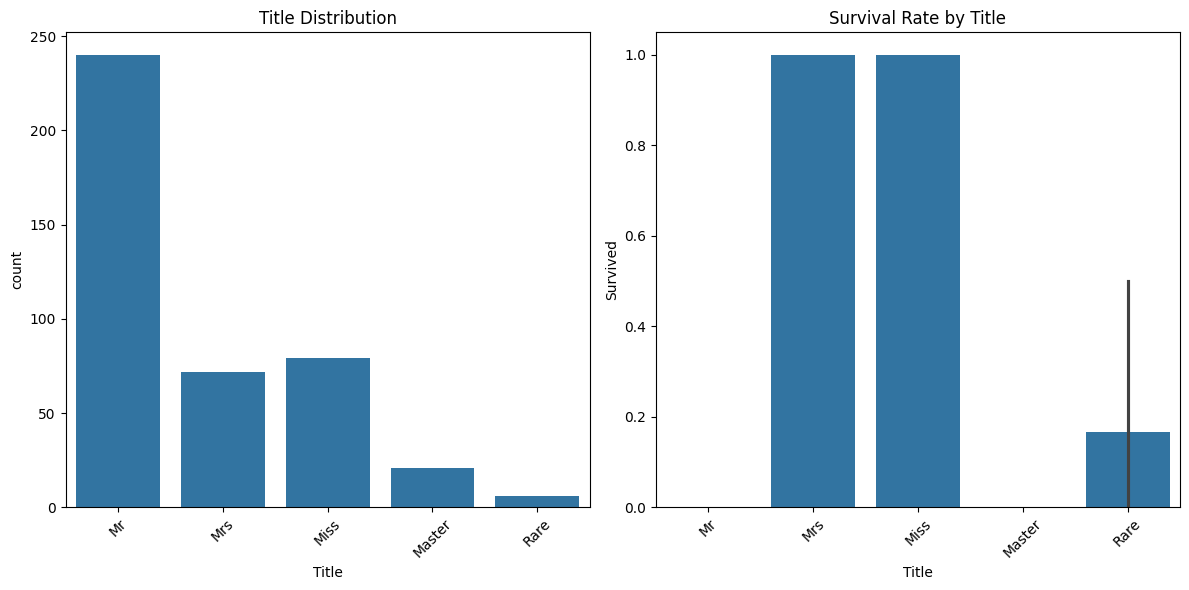

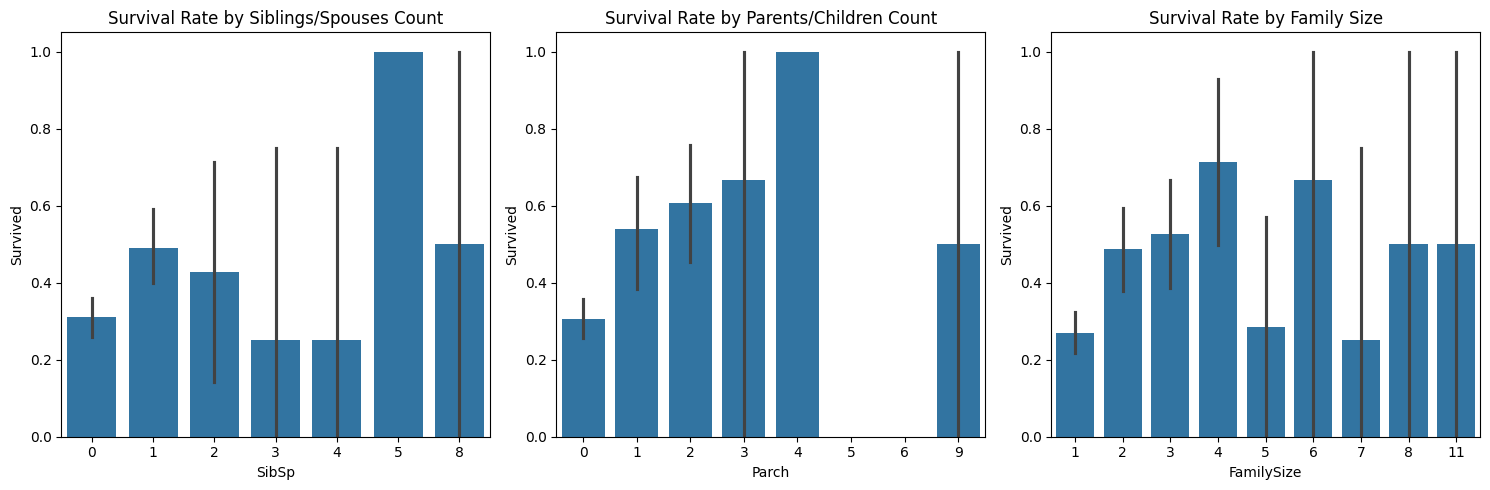

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_survival_by_features(df):
    """Plot survival rates across different features"""
    plt.figure(figsize=(20, 20))

    # Define the subplots
    plt.subplot(3, 3, 1)
    sns.barplot(x='Pclass', y='Survived', data=df)
    plt.title('Survival Rate by Passenger Class')

    plt.subplot(3, 3, 2)
    sns.barplot(x='Sex', y='Survived', data=df)
    plt.title('Survival Rate by Gender')

    plt.subplot(3, 3, 3)
    sns.barplot(x='Embarked', y='Survived', data=df)
    plt.title('Survival Rate by Embarkation Port')

    plt.subplot(3, 3, 4)
    sns.barplot(x='IsAlone', y='Survived', data=df)
    plt.title('Survival Rate by Traveling Alone')

    plt.subplot(3, 3, 5)
    sns.barplot(x='Title', y='Survived', data=df)
    plt.title('Survival Rate by Title')
    plt.xticks(rotation=45)

    plt.subplot(3, 3, 6)
    sns.barplot(x='Deck', y='Survived', data=df)
    plt.title('Survival Rate by Deck')
    plt.xticks(rotation=45)

    plt.subplot(3, 3, 7)
    sns.barplot(x='FareBin', y='Survived', data=df)
    plt.title('Survival Rate by Fare Bins')

    plt.subplot(3, 3, 8)
    sns.barplot(x='AgeBin', y='Survived', data=df)
    plt.title('Survival Rate by Age Bins')

    plt.subplot(3, 3, 9)
    sns.barplot(x='FamilySize', y='Survived', data=df)
    plt.title('Survival Rate by Family Size')

    plt.tight_layout()
    plt.show()

def plot_age_distribution(df):
    """Plot age distribution with survival breakdown"""
    plt.figure(figsize=(12, 6))

    # Plot age distribution
    plt.subplot(1, 2, 1)
    sns.histplot(df['Age'].dropna(), bins=30, kde=True)
    plt.title('Age Distribution')

    # Plot age distribution by survival
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x='Age', hue='Survived', bins=30, kde=True, multiple='stack')
    plt.title('Age Distribution by Survival')

    plt.tight_layout()
    plt.show()

def plot_fare_distribution(df):
    """Plot fare distribution with survival breakdown"""
    plt.figure(figsize=(12, 6))

    # Plot fare distribution
    plt.subplot(1, 2, 1)
    sns.histplot(df['Fare'], bins=30, kde=True)
    plt.title('Fare Distribution')

    # Plot fare distribution by survival
    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x='Fare', hue='Survived', bins=30, kde=True, multiple='stack')
    plt.title('Fare Distribution by Survival')

    plt.tight_layout()
    plt.show()

def plot_cross_features(df):
    """Plot cross-feature relationships with survival"""
    plt.figure(figsize=(20, 15))

    # Pclass vs Sex
    plt.subplot(2, 2, 1)
    sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df)
    plt.title('Survival Rate by Class and Gender')

    # Pclass vs Age
    plt.subplot(2, 2, 2)
    sns.boxplot(x='Pclass', y='Age', hue='Survived', data=df)
    plt.title('Age Distribution by Class and Survival')

    # Embarked vs Pclass
    plt.subplot(2, 2, 3)
    sns.barplot(x='Embarked', y='Survived', hue='Pclass', data=df)
    plt.title('Survival Rate by Embarkation Port and Class')

    # FamilySize vs Pclass
    plt.subplot(2, 2, 4)
    sns.barplot(x='FamilySize', y='Survived', hue='Pclass', data=df)
    plt.title('Survival Rate by Family Size and Class')

    plt.tight_layout()
    plt.show()

def plot_correlation_heatmap(df):
    """Plot correlation heatmap of numerical features"""
    plt.figure(figsize=(12, 8))

    # Select numerical features
    numerical_df = df.select_dtypes(include=['int64', 'float64'])

    # Calculate correlation matrix
    corr = numerical_df.corr()

    # Plot heatmap
    sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.show()

def plot_pairplot(df):
    """Plot pairplot of numerical features with survival hue"""
    sns.pairplot(df[['Age', 'Fare', 'SibSp', 'Parch', 'FamilySize', 'Survived']],
                 hue='Survived', plot_kws={'alpha':0.5})
    plt.suptitle('Pairplot of Numerical Features', y=1.02)
    plt.show()

def plot_violin_plots(df):
    """Plot violin plots showing distribution of features by survival"""
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    sns.violinplot(x='Survived', y='Age', data=df)
    plt.title('Age Distribution by Survival')

    plt.subplot(2, 2, 2)
    sns.violinplot(x='Survived', y='Fare', data=df)
    plt.title('Fare Distribution by Survival')

    plt.subplot(2, 2, 3)
    sns.violinplot(x='Survived', y='SibSp', data=df)
    plt.title('Siblings/Spouses Distribution by Survival')

    plt.subplot(2, 2, 4)
    sns.violinplot(x='Survived', y='Parch', data=df)
    plt.title('Parents/Children Distribution by Survival')

    plt.tight_layout()
    plt.show()

def plot_deck_survival(df):
    """Plot survival rates by deck with passenger class breakdown"""
    if 'Deck' in df.columns:
        plt.figure(figsize=(12, 6))
        sns.barplot(x='Deck', y='Survived', hue='Pclass', data=df)
        plt.title('Survival Rate by Deck with Class Breakdown')
        plt.show()

def plot_title_distribution(df):
    """Plot distribution of titles and their survival rates"""
    if 'Title' in df.columns:
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        sns.countplot(x='Title', data=df)
        plt.title('Title Distribution')
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        sns.barplot(x='Title', y='Survived', data=df)
        plt.title('Survival Rate by Title')
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()

def plot_family_relationships(df):
    """Plot family relationships and survival"""
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    sns.barplot(x='SibSp', y='Survived', data=df)
    plt.title('Survival Rate by Siblings/Spouses Count')

    plt.subplot(1, 3, 2)
    sns.barplot(x='Parch', y='Survived', data=df)
    plt.title('Survival Rate by Parents/Children Count')

    plt.subplot(1, 3, 3)
    sns.barplot(x='FamilySize', y='Survived', data=df)
    plt.title('Survival Rate by Family Size')

    plt.tight_layout()
    plt.show()

# Example usage:
# Load your preprocessed dataframe first
# df = pd.read_csv('tested.csv')
# df = preprocess_data(df)  # Use your preprocessing function

# Then call the visualization functions:
plot_survival_by_features(df)
plot_age_distribution(df)
plot_fare_distribution(df)
plot_cross_features(df)
plot_correlation_heatmap(df)
plot_pairplot(df)
plot_violin_plots(df)
plot_deck_survival(df)
plot_title_distribution(df)
plot_family_relationships(df)